<br>

## Installlation and imports

In [1]:
!pip install -q transformers sentencePiece

     |████████████████████████████████| 3.8 MB 9.1 MB/s 
     |████████████████████████████████| 1.2 MB 84.2 MB/s 
     |████████████████████████████████| 895 kB 48.7 MB/s 
     |████████████████████████████████| 596 kB 56.1 MB/s 
     |████████████████████████████████| 6.5 MB 45.6 MB/s 
     |████████████████████████████████| 67 kB 6.5 MB/s 


In [39]:
import re
import os
import time
import torch
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from transformers import AlbertTokenizer, AutoModel, pipeline

In [14]:
from sklearn.preprocessing import LabelEncoder

In [35]:
from torch.utils.data import Dataset, DataLoader

<br>

Mount drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<br>

## Load data

In [4]:
fname = '/content/drive/Othercomputers/My MacBook Pro/MIE1517_nlp_proteins/data/postprocessedECnumToSeq-edited.csv'
seq_data = pd.read_csv(
    fname, 
    index_col = 0    
)

In [5]:
seq_data.head()

,EC Number,Level 1,Level 2,Level 3,Level 4,sequence
0,1,1,NaN,NaN,NaN,TKDNLTGDIVIIGAGAAGSLLAHYLARFSNMKIILLEAGHSHFNDP...
1,1,1,NaN,NaN,NaN,MHHHHHHSSGVDLGTENLYFQSNAMNISRKTALVTGASRGIGRAIA...
2,1,1,NaN,NaN,NaN,QGMIMTSDIKLLDYLRVRRSTPALQLSEPGPSKGEIEEILRLAVRV...
3,1,1,NaN,NaN,NaN,AMVSSSCSSIPKMPVTPLSLVTRHVAIIGAGAAGLVTARELRREGH...
4,1,1,NaN,NaN,NaN,MADLNQRRQRSEFQSKIKILLSTTIKAKPELVPSLLKLALNDAMTY...


In [6]:
print(seq_data.shape)

(16994, 6)


<br>

## Perform data pre-processing

<br>

Subset columns

In [7]:
cols = ['EC Number', 'sequence']
seq_data = seq_data[cols]

<br>

Change column names

In [8]:
seq_data.columns = ['ECNumber', 'sequence']

<br>

Drop NaNs

In [9]:
seq_data = seq_data.dropna()

<br>

Add column with sequence length

In [10]:
seq_data['seg_length'] = seq_data['sequence'].apply(len)

<br>

Plot histogram of sequence length and highlight the threshold

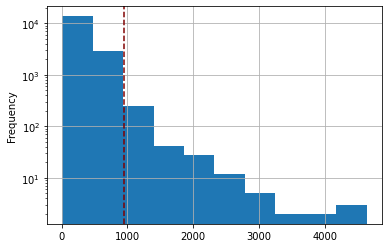

In [11]:
length_th = 950
seq_data['seg_length'].plot.hist()
plt.axvline(length_th, ls = '--', color = 'maroon')
plt.yscale('log')
plt.grid()
plt.show()

<br>

Filter data by length

In [12]:
seq_data = seq_data[seq_data['seg_length'] <= length_th]

In [15]:
ec_encoder = LabelEncoder()
seq_data.loc[:,'ECLabel'] = ec_encoder.fit_transform(seq_data['ECNumber'])

In [16]:
print(seq_data.shape)

(16660, 4)


In [17]:
seq_data.head()

,ECNumber,sequence,seg_length,ECLabel
0,1,TKDNLTGDIVIIGAGAAGSLLAHYLARFSNMKIILLEAGHSHFNDP...,652,0
1,1,MHHHHHHSSGVDLGTENLYFQSNAMNISRKTALVTGASRGIGRAIA...,269,0
2,1,QGMIMTSDIKLLDYLRVRRSTPALQLSEPGPSKGEIEEILRLAVRV...,197,0
3,1,AMVSSSCSSIPKMPVTPLSLVTRHVAIIGAGAAGLVTARELRREGH...,458,0
4,1,MADLNQRRQRSEFQSKIKILLSTTIKAKPELVPSLLKLALNDAMTY...,268,0


<br>

## Initiate protAlbert tokenizer and model

In [18]:
tokenizer = AlbertTokenizer.from_pretrained(
    "Rostlab/prot_albert", 
    do_lower_case=False 
)

Downloading:   0%|          | 0.00/233k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

In [19]:
albert_model = AutoModel.from_pretrained("Rostlab/prot_albert")

Downloading:   0%|          | 0.00/856M [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_albert were not used when initializing AlbertModel: ['predictions.bias', 'predictions.decoder.weight', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.bias', 'predictions.dense.bias', 'predictions.decoder.bias', 'predictions.dense.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [51]:
emb_pipe = pipeline('feature-extraction', model=albert_model, tokenizer=tokenizer, device=0)

In [53]:
sequences = seq_data['sequence'].values[:100]
sequences = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences]
res = emb_pipe(sequences)

In [56]:
np.array(res).shape

(100, 1, 3, 4096)

<br>

## Tokenize sequences

In [36]:
class seqDataset(Dataset):
    def __init__(self, input_ids, token_type_ids, attention_mask):
        super().__init__()
        assert len(input_ids) == len(token_type_ids)
        assert len(input_ids) == len(attention_mask)
        
        # Add dataset size
        self.n = len(input_ids)

        # Add input ids, token type ids and attention mask to class
        self.input_ids = torch.as_tensor(input_ids)
        self.token_type_ids = torch.as_tensor(token_type_ids)
        self.attention_mask = torch.as_tensor(attention_mask)
            
    def __len__(self):
        return self.n

    def __getitem__(self, idx):
        return self.input_ids[idx], self.token_type_ids[idx], self.attention_mask[idx,:]

<br>

Create sequence tokens

In [27]:
sequences_list = seq_data['sequence'].values[:100]
tokens = tokenizer.batch_encode_plus(
    sequences_list, 
    add_special_tokens=True, 
)

<br>

Create a dataset

In [37]:
dataset = seqDataset(**tokens)

In [38]:
print(len(dataset))

100


<br>

## Get sequence representations

In [ ]:
class sequenceEmbedder():
    def __init__(self, model, dataset, batch_size = 16, num_layers = 33, device = 'cuda'):
        self.device = device
        self.model = model
        self.num_layers = num_layers
        self.batch_size = batch_size

        # Initiate data loader
        self.loader = DataLoader(
            dataset, 
            batch_size=self.batch_size,
            shuffle = False
        )
        
        # Set to eval model
        self.model.eval()

        # Set device
        if self.device == torch.device('cuda'):
            torch.cuda.empty_cache()
        self.model.to(device)

    def average_tokens(self, lengths, representations):
        seq_reps = []
        for i, l in enumerate(lengths):
            k = l + 1
            representation = representations[i]           
            r = representation[1:k,:].mean(0)
            seq_reps.append(r)
        seq_reps = torch.stack(seq_reps)
        return seq_reps

    def get_embeddings(self, verbosity = 100):
        # Init containers         
        embeddings = [] 
        all_labels = []        
        with torch.no_grad():
            start = time.time()
            for i, (ids, type_ids, mask) in enumerate(self.loader):
                # Set device
                tokens = tokens.to(device)

                # Get model embeddings
                emb = self.model(
                    tokens, 
                    repr_layers = [self.num_layers], 
                    return_contacts = False
                )

                # Extract token representations
                token_representations = res['representations'][self.num_layers]

                # Average across tokens
                sequence_representations = self.average_tokens(lengths, token_representations)

                # Detach and bring to cpu (unload gpu)
                sequence_representations = sequence_representations.detach().cpu()

                # Add to containers
                embeddings.append(sequence_representations)
                all_labels.append(labels)

                if i % verbosity == 0:
                    print('Batch no. {}; Sequence no.: {}; Elapsed time: {:1.2f}'.format(i + 1, (i + 1) * self.batch_size, time.time() - start))

            # Concat
            embeddings = torch.cat(embeddings)
            all_labels = torch.cat(all_labels)

        return embeddings, all_labels

In [40]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [41]:
albert_model = albert_model.to(device)
albert_model = albert_model.eval()

In [43]:
x = dataset.input_ids.to(device)
y = dataset.attention_mask.to(device)
res = albert_model(input_ids=x,attention_mask=y)

In [46]:
res[0].shape

torch.Size([100, 3, 4096])

In [48]:
res[1].shape

torch.Size([100, 4096])

In [ ]:
sequences_3000 =  [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences_3000]

In [ ]:
input_ids = torch.tensor(ids['input_ids']).to(device)
attention_mask = torch.tensor(ids['attention_mask']).to(device)

In [ ]:
with torch.no_grad():
    embedding = albert_model(input_ids=input_ids,attention_mask=attention_mask)[0]

embedding = embedding.cpu().numpy()
embedding.shape

(3000, 3, 4096)

In [ ]:
features = [] 
for seq_num in range(len(embedding)):
    seq_len = (attention_mask[seq_num] == 1).sum()
    seq_emd = embedding[seq_num][1:seq_len-1]
    features.append(seq_emd)

In [ ]:
y = postproc_1['Level 1'][index].to_numpy()
y = y - 1

In [ ]:
y.shape

(3000,)

## Splitting into train, test, valid + Batching

In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_test, y_tr, y_test = train_test_split(embedding, y, test_size = 0.2, random_state = 0, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size = 1/4, random_state = 0, stratify = y_tr)
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(1800, 3, 4096) (600, 3, 4096) (600, 3, 4096) (1800,) (600,) (600,)


In [ ]:
from torch.utils import data as data

class LoaderClass(data.Dataset):
  def __init__(self, embedding, label):
    super(LoaderClass, self).__init__()
    self.embedding = embedding
    self.label = label
  def __len__(self):
    return self.embedding.shape[0]
  def __getitem__(self, idx):
    return self.embedding[idx], self.label[idx]

In [ ]:
X_train.shape

(1800, 3, 4096)

In [ ]:
batch_size = 32
train_loader = data.DataLoader(LoaderClass(X_train, y_train), batch_size, True)
valid_loader = data.DataLoader(LoaderClass(X_val, y_val), batch_size, True)
test_loader = data.DataLoader(LoaderClass(X_test, y_test), batch_size, True)

In [ ]:
for embedding, label in train_loader:
  print(embedding.shape)
  print(label.shape)
  break

torch.Size([64, 3, 4096])
torch.Size([64])


## Defining get accuracy

In [ ]:
def get_accuracy(model, data_loader):
  correct, total = 0, 0 
  for sequences, labels in data_loader:

    if use_cuda and torch.cuda.is_available():
      sequences = sequences.cuda()
      labels = labels.cuda()

    output = model(sequences)
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += labels.shape[0]
  return correct/total

## Creating model class and defining training function

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        #print(x)
        # Set an initial hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(device)
        # Forward propagate the RNN
        out, _ = self.rnn(x, h0)
        # out = torch.cat([torch.max(out, dim=1)[0], 
        #                 torch.mean(out, dim=1)], dim=1)
        # Pass the output of the last time step to the classifier
        
        #out = self.fc(out)
        # out = self.dropout(out)
        # out = torch.tanh(out)
        out = self.fc(out[:, -1, :])

        return out

In [ ]:
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5, use_cuda = False):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for sequences, labels in train:
            if use_cuda and torch.cuda.is_available():
              sequences = sequences.cuda()
              labels = labels.cuda()
              model = model.cuda()

            optimizer.zero_grad()
            pred = model(sequences)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        if epoch % 5 == 4:
          epochs.append(epoch)
          train_acc.append(get_accuracy(model, train_loader))
          valid_acc.append(get_accuracy(model, valid_loader))
          print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
                epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

In [ ]:
def train_network_accuracy(model, train, valid, num_epochs=5, learning_rate=1e-5, use_cuda = False):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for sequences, labels in train:
            if use_cuda and torch.cuda.is_available():
              sequences = sequences.cuda()
              labels = labels.cuda()
              model = model.cuda()

            optimizer.zero_grad()
            pred = model(sequences)
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        #if epoch % 5 == 4:
        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train_loader))
        valid_acc.append(get_accuracy(model, valid_loader))
        print("Epoch %d; Loss %f; Train Acc %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))

In [ ]:
class_count = y_train
unique, counts = np.unique(class_count, return_counts=True)

print(np.asarray((unique, counts)))

[[  0   1   2   3   4   5   6]
 [306 548 604 150  92  81  19]]


CUDA is available! Training on GPU...
Epoch 5; Loss 1.960745; Train Acc 0.304444; Val Acc 0.305000
Epoch 10; Loss 1.463104; Train Acc 0.304444; Val Acc 0.305000
Epoch 15; Loss 1.537465; Train Acc 0.335556; Val Acc 0.336667
Epoch 20; Loss 2.437173; Train Acc 0.335556; Val Acc 0.336667
Epoch 25; Loss 1.375073; Train Acc 0.335556; Val Acc 0.336667
Epoch 30; Loss 1.265493; Train Acc 0.335556; Val Acc 0.336667
Epoch 35; Loss 2.070537; Train Acc 0.335556; Val Acc 0.336667
Epoch 40; Loss 2.305042; Train Acc 0.335556; Val Acc 0.336667
Epoch 45; Loss 1.251002; Train Acc 0.304444; Val Acc 0.305000
Epoch 50; Loss 2.176408; Train Acc 0.335556; Val Acc 0.336667


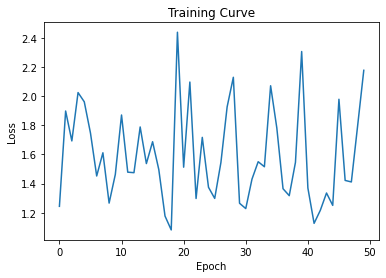

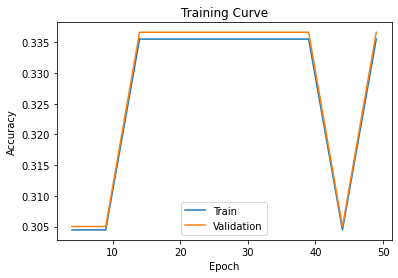

In [ ]:
use_cuda = True
in_size = X_train.shape[2]
classes= len(np.unique(y_train))

model = SimpleRNN(in_size, 10000, classes)

if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available! Training on GPU...')
else:
  print('CUDA is not available. Training on CPU...')

train_rnn_network(model, train_loader, valid_loader, num_epochs=50, learning_rate=1e-4, use_cuda = True)

In [ ]:
hidden_nodes = [10, 100, 500, 1000, 2000, 5000, 10000, 15000]

for hidden in hidden_nodes:
    model = SimpleRNN(in_size, hidden, classes)

  if use_cuda and torch.cuda.is_available():
    model.cuda()
    print('CUDA is available! Training on GPU...')
  else:
    print('CUDA is not available. Training on CPU...')

  train_network_accuracy(model, train_loader, valid_loader, num_epochs=50, learning_rate=1e-4, use_cuda = True)

IndentationError: ignored

In [ ]:
in_size = X_train.shape[2]
classes= len(np.unique(y_train))
classes

7

In [ ]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6])

In [ ]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(SimpleLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers = num_layers, batch_first=True)
        self.fc = nn.Linear(2 * hidden_size, num_classes)
    
    def forward(self, x):
        #print(x)
        # Set an initial hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Forward propagate the RNN
        out, _ = self.rnn(x, (h0, c0))
        out = torch.cat([torch.max(out, dim=1)[0], 
                        torch.mean(out, dim=1)], dim=1)
        # Pass the output of the last time step to the classifier
        out = self.fc(out)

        return out

In [ ]:
model_lstm = SimpleLSTM(in_size, 4000, 3, classes)
train_rnn_network(model_lstm, train_loader, valid_loader, num_epochs=100, learning_rate=5e-4, use_cuda = True)

NameError: ignored

In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
model

SimpleRNN(
  (rnn): RNN(4096, 2000, batch_first=True)
  (fc): Linear(in_features=2000, out_features=8, bias=True)
)